# Figure 4

Fit the model where there is a non-linear relationship between neighbors in the highest fidelity, and subsequent fidelities are block-wise averages of the previous fidelity.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Packages for data loading
import pathlib
import pickle

# Packages for working with array data and tensors]
import numpy as np
import matplotlib.pyplot as plt
import torch

# Packages for building transport maps
import veccs.orderings
from batram.legmods import SimpleTM

c:\Users\Aleja\anaconda3\envs\batram-mf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# after the imports set a seed for reproducibility
# anyhow, the results will be different on different machines
# cf. https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(0)
torch.manual_seed(0)

### Data Loading and Inspection

Our model assumes we are loading datasets of the following structure:
- An $N \times d$ array of spatial locations indexing the dataset
- An $n \times N$ array of observations at the $N$ indexed locations

Below we load a test dataset. The data consist of 200 replications of a
spatial field on a 30 x 30 grid over the unit square; i.e., there are $n=200$
samples of a process defined on $(0, 1)^2$ with 30 evenly spaced points in each
dimension.

In [3]:
# Load data and print dimensions
data_fp = pathlib.Path("../tests/data/data_mf.pkl")
with open(data_fp, "rb") as fh:
    data_pkl: dict[str, np.ndarray] = pickle.load(fh)

locs_lf = data_pkl["locs_lf"]
locs_mf = data_pkl["locs_mf"]
locs_hf = data_pkl["locs_hf"]

obs_lf = data_pkl["obs_lf"]
obs_mf = data_pkl["obs_mf"]
obs_hf = data_pkl["obs_hf"]

To get an idea of what the data look like, we plot the first 40 spatial fields for each fidelity: First low fidelity.

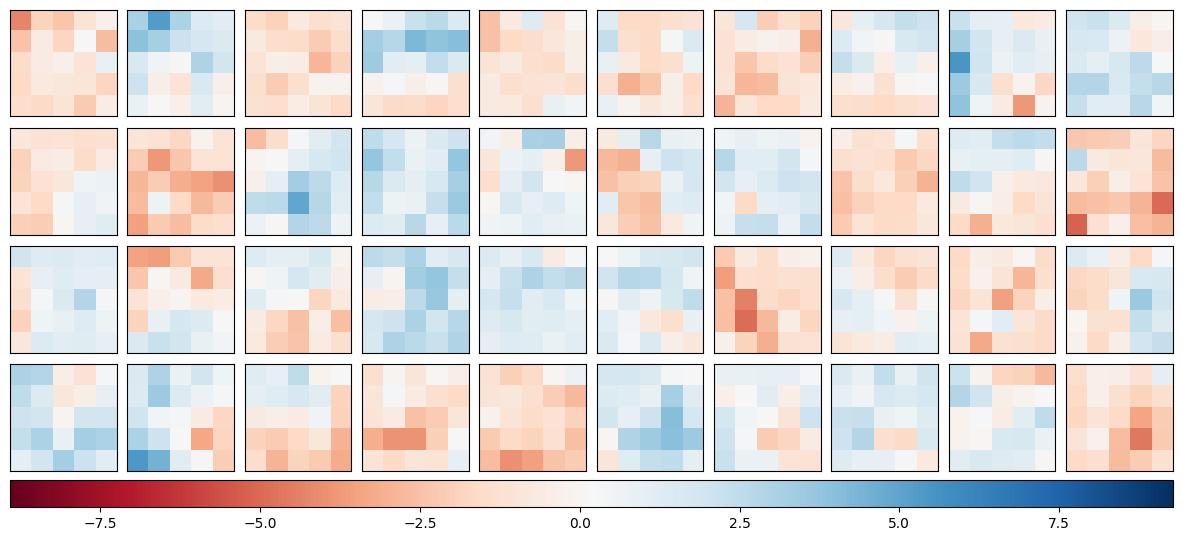

In [4]:
gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
vmin, vmax = obs_hf[:40].min(), obs_hf[:40].max()
plt.set_cmap('RdBu')
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(obs_lf[i].reshape(5, 5), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

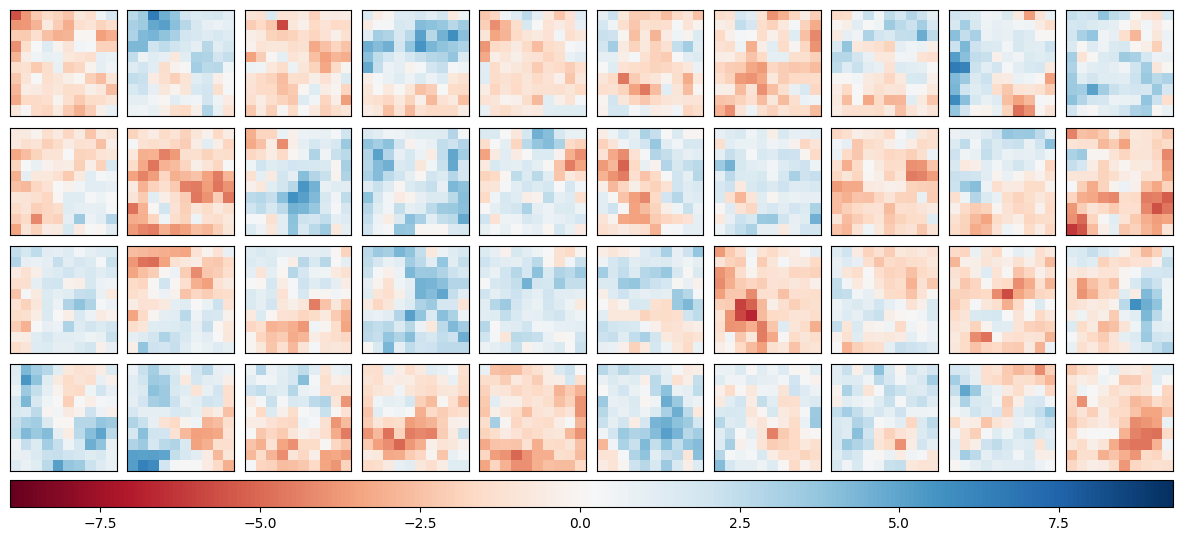

In [5]:
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(obs_mf[i].reshape(10, 10), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

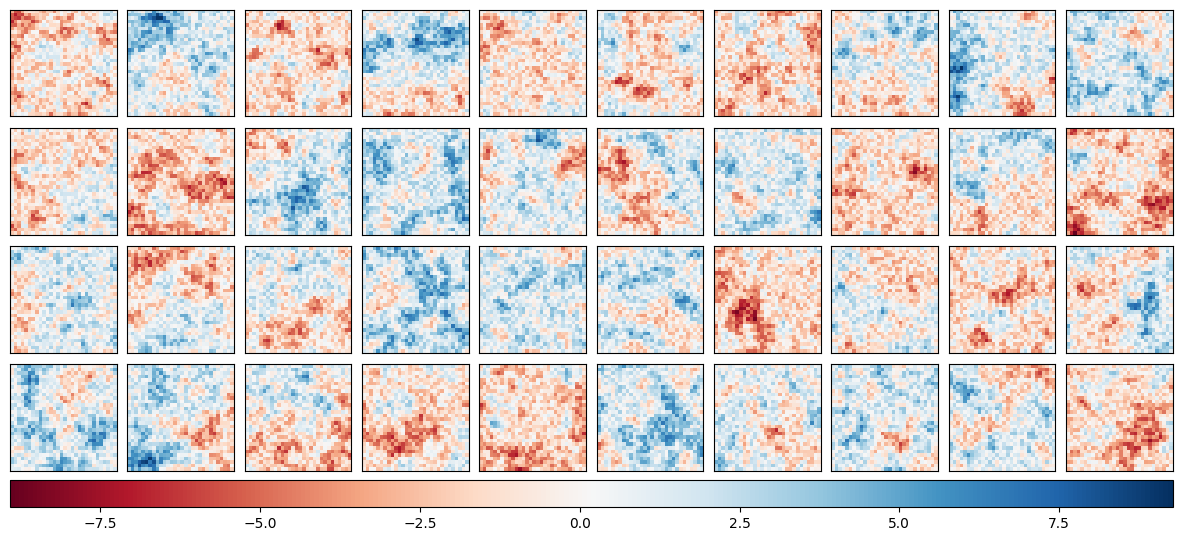

In [6]:
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(obs_hf[i].reshape(30, 30), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

### Data Preprocessing and Map Initialization

Our models assume the data have been pixel-wise centered and an ordering of the
data has been computed. We also require nearest neighbor information to fit the
model. The centering is easy to do using numpy or pytorch arrays, and the `veccs`
package provides the required functionality for the remaining steps. The next
code block demonstrates the typical preprocessing steps, then stores the
transformed data in a `Data` container.

In [7]:
from scipy.spatial.distance import cdist

# The loaded data contained 200 replicate spatial fields (200 samples, 900 locs).
# We will subset the data to use the first 50 samples for each fidelity
obs_lf_train = obs_lf[:50, :]
obs_mf_train = obs_mf[:50, :]
obs_hf_train = obs_hf[:50, :]

# Always using this test set of 50 samples
obs_lf_test = obs_lf[200:250, :]
obs_mf_test = obs_mf[200:250, :]
obs_hf_test = obs_hf[200:250, :]

# Pixel-wise data centering, so that each pixel is mean zero
# variance 1)

mean_lf = obs_lf.mean(dim=0, keepdim = True)
sd_lf = obs_lf.std(dim=0, keepdim= True)
mean_mf = obs_mf.mean(dim=0, keepdim=True)
sd_mf = obs_mf.std(dim = 0, keepdim=True)
mean_hf = obs_hf.mean(dim = 0, keepdim=True)
sd_hf = obs_hf.std(dim=0, keepdim=True)
obs_lf = (obs_lf_train - mean_lf)/sd_lf
obs_mf = (obs_mf_train - mean_mf)/sd_mf
obs_hf = (obs_hf_train - mean_hf)/sd_hf
obs = torch.hstack((obs_lf, obs_mf, obs_hf))

obs_lf_test = (obs_lf_test - mean_lf)/sd_lf
obs_mf_test = (obs_mf_test - mean_mf)/sd_mf
obs_hf_test = (obs_hf_test - mean_hf)/sd_hf
obs_test = torch.hstack((obs_lf_test, obs_mf_test, obs_hf_test))

Let's compute $\ell_{i}$ and plot it wrt to $i$. Should be decreasing, but for multifidelity scenarios we can get a slight bump on the first indices of a new fidelity, when lower fidelity points are closer than the first few higher fidelity points to the lower fidelity. The code will still work if that happens, but adding an additional $\epsilon_r$ coordinate (e.g. $\epsilon_r = \min_{j,j' \in \{1, \dots, N_{r+1} \}} ||s_{r+1,j} - s_{r+1,j'}||^2/2$) seems to do the trick also, and is recommended for better numerical stability. Also, if lower fidelity and higher fidelity grids share locations, some $\ell_i$ will be $0$ and the model will be very numerically unstable, the fix is also adding the additional $\epsilon_r$. For the last fidelity, set $\epsilon_R = 0$. 

In [8]:
dist_mf = cdist(locs_mf, locs_mf)
epsilon_1 = dist_mf[dist_mf!=0.0].min()/3
epsilon_1_col = torch.zeros(25, 1) + epsilon_1
locs_lf = torch.hstack((locs_lf, epsilon_1_col))
locs_lf.shape

torch.Size([25, 3])

In [9]:
dist_hf = cdist(locs_hf, locs_hf)
epsilon_2 = dist_hf[dist_hf!=0.0].min()/3
epsilon_2_col = torch.zeros(100, 1) + epsilon_2
locs_mf = torch.hstack((locs_mf, epsilon_2_col))
locs_mf.shape

torch.Size([100, 3])

In [10]:
locs_hf = torch.hstack((locs_hf, torch.zeros(900,1)))
locs = torch.vstack((locs_lf, locs_mf, locs_hf))
locs.shape

torch.Size([1025, 3])

In [ ]:
from veccs.orderings import maxmin_pred_cpp, find_nns_l2_mf

ord_lfmf = maxmin_pred_cpp(locs_lf.detach().numpy(), locs_mf.detach().numpy())

locs_lfmf = np.vstack((locs_lf, locs_mf))
ord_hf = maxmin_pred_cpp(locs_lfmf, locs_hf.detach().numpy())

ord = np.concatenate((ord_lfmf, ord_hf[125:]))
locs_ord = locs[ord, ...]

locs_all = [locs_ord[:25], locs_ord[25:125], locs_ord[125:]]
largest_conditioning_set = 50
nn = find_nns_l2_mf(locs_all, largest_conditioning_set)

ord_lf = ord[:25]
ord_mf = ord[25:125] - 100
ord_hf = ord[125:] - 125

obs_ord = obs[..., ord]
obs_test_ord = obs_test[..., ord]

In [12]:
from batram.data import MultiFidelityData, AugmentDataMF

fidelity_sizes = torch.as_tensor(list(map(len, locs_all)))
data = MultiFidelityData.new(locs_ord, obs_ord, torch.as_tensor(nn), fidelity_sizes)
data_augmented = AugmentDataMF()
aug_data = data_augmented(data)
data.response[:, 0].square().mean().log()
scales = aug_data.scales

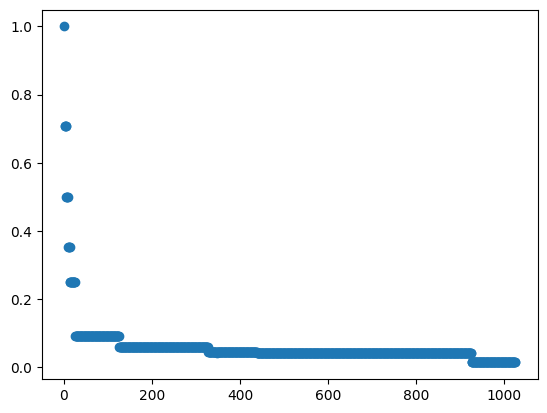

In [13]:
x = range(1, 1026)
plt.scatter(x, scales)

In [14]:
R = 3
theta_init = torch.zeros((9*R-2))
log_2m = data.response[:, 0].square().mean().log()
# Nugget 1
theta_init[:R] = log_2m
# Nugget 2
theta_init[R:2*R] = 0.2
# Sigma 1
theta_init[2*R:3*R] = 0.0
# Sigma 2
theta_init[3*R:4*R] = 0.0
# Theta q 0 within
theta_init[4*R:5*R] = 0.0
# Theta q 1 within
theta_init[5*R:6*R] = 0.0
# Theta q 0 between
theta_init[6*R:7*R-1] = 0.0
# Theta q 1 between
theta_init[7*R-1:8*R-2]
# Theta gammas
theta_init[8*R-2:9*R-2] = -1.0

In [15]:
from batram.mf import MultiFidelityTM

tm = MultiFidelityTM(data, theta_init, nug_mult = 4.0)
# The `nsteps` argument is always required. When using a user-defined optimizer
# we ignore the initial learning rate. The `batch_size` specifies how to perform
# minibatch gradient descent. The `test_data` argument is optional and is used
# to compute the test loss at each step.
nsteps = 200
opt = torch.optim.Adam(tm.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
res = tm.fit(
    nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched
)

Train Loss: -3888.754, Test Loss: -3889.565: 100%|██████████| 200/200 [01:18<00:00,  2.56it/s]


# Loss

C:\Users\Aleja\AppData\Local\Temp\ipykernel_22220\3146070393.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


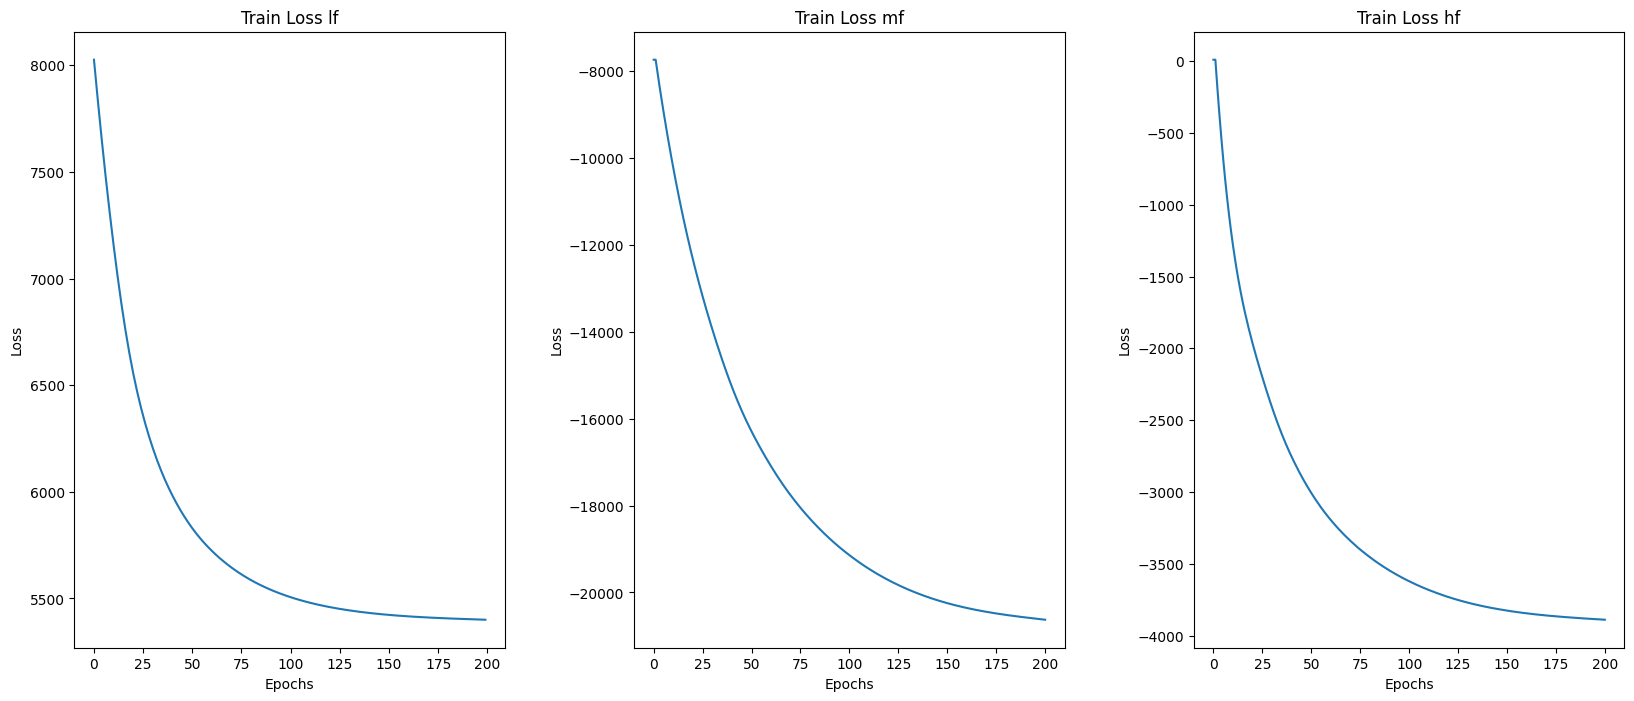

In [16]:
import matplotlib.pyplot as plt

gspec = {"wspace": 0.3, "hspace": 0.1}
fig, ax = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw=gspec)
ax[0].plot(res.losses[1:nsteps+1])
ax[0].set_title('Train Loss lf')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(res.losses[nsteps+1:2*nsteps+2])
ax[1].set_title('Train Loss mf')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

ax[2].plot(res.losses[2*nsteps+2:])
ax[2].set_title('Train Loss hf')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
plt.tight_layout()
plt.show()

# Visualizing the obtained parameters

One check is to just see the raw parameter values and see if the obtained values converge, which they seem to do here. 

# Nearest Neighbors

First the raw parameters, $\theta_{q,0}$ and $\theta_{q,1}$ for each fidelity and between fidelities. By Matthias' and Paul's suggestions, we have scaling to be

$$ exp(\theta_{q,0}^{(r,r)} - \theta_{q,1}^{(r,r)}k) $$

with $k$ is the number of neighbors. For finding neighbors on the previous fidelity

$$ exp(\theta_{q,0}^{(r,r-1)} - \theta_{q,1}^{(r,r-1)}k) $$



Text(0.5, 1.0, 'High fidelity parameters')

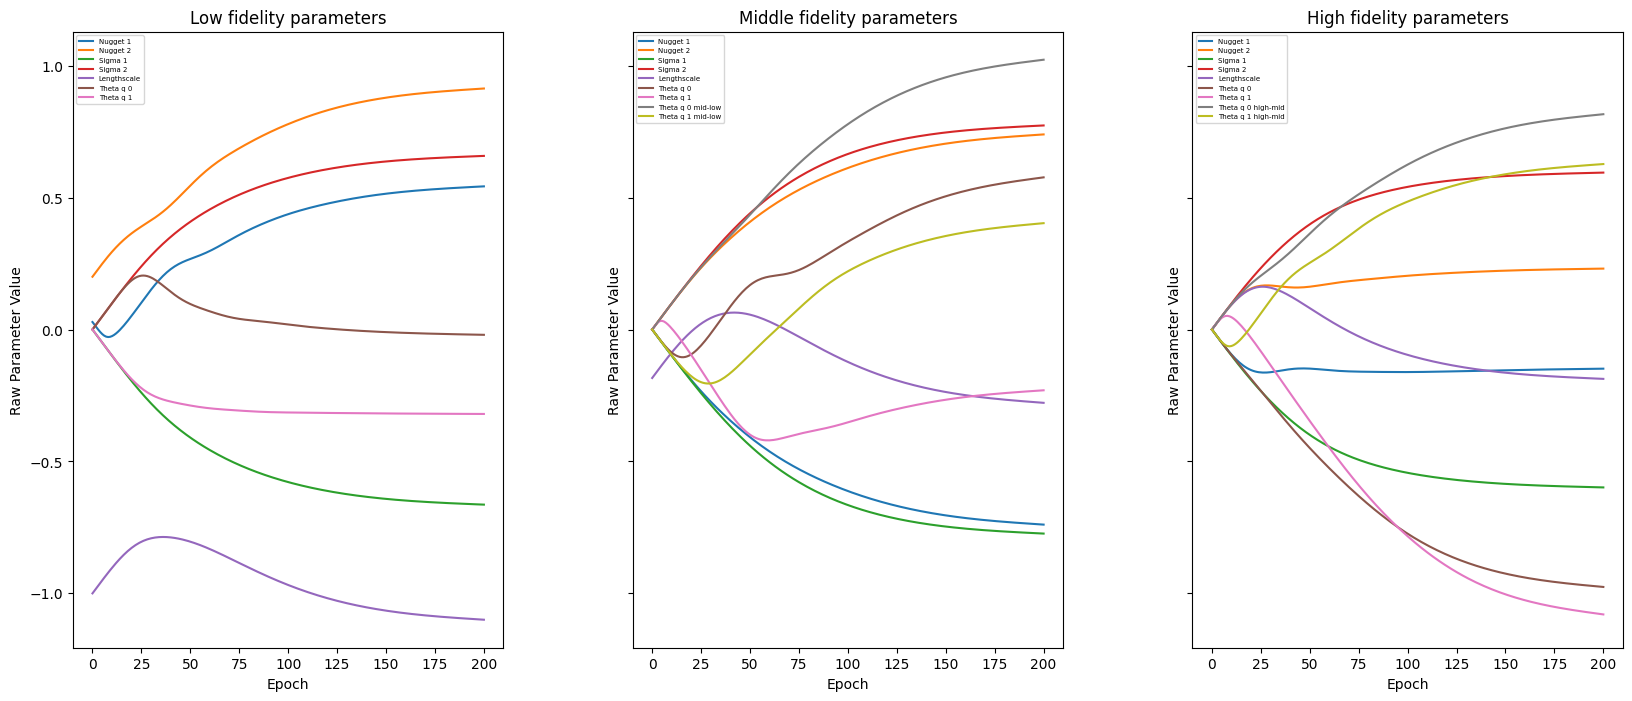

In [17]:
gspec = {"wspace": 0.3, "hspace": 0.1}
fig, ax = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw=gspec, sharey=True)
labels=["Nugget 1", "Nugget 2", "Sigma 1", "Sigma 2", "Lengthscale", "Theta q 0", 
        "Theta q 1"]
to_plot = [res.param_chain["nugget.nugget_params"][:nsteps+1,0], res.param_chain["nugget.nugget_params"][:nsteps+1,3],
           res.param_chain["kernel.sigma_params"][:nsteps+1,0], res.param_chain["kernel.sigma_params"][:nsteps+1,3],
           res.param_chain["kernel.lengthscale"][:nsteps+1,0], res.param_chain["kernel.theta_q"][:nsteps+1,0], 
           res.param_chain["kernel.theta_q"][:nsteps+1,3]]
param_chain = np.vstack(to_plot).transpose()
ax[0].plot(param_chain, label = labels)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Raw Parameter Value")
ax[0].legend(loc=2, prop={'size': 5})
ax[0].set_title('Low fidelity parameters')

labels=["Nugget 1", "Nugget 2", "Sigma 1", "Sigma 2", "Lengthscale", "Theta q 0", 
        "Theta q 1", "Theta q 0 mid-low", "Theta q 1 mid-low"]
to_plot = [res.param_chain["nugget.nugget_params"][nsteps+1:2*nsteps+2,1], res.param_chain["nugget.nugget_params"][nsteps+1:2*nsteps+2,4],
           res.param_chain["kernel.sigma_params"][nsteps+1:2*nsteps+2,1], res.param_chain["kernel.sigma_params"][nsteps+1:2*nsteps+2,4],
           res.param_chain["kernel.lengthscale"][nsteps+1:2*nsteps+2,1], res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,1], 
           res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,4], res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 6],
           res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 8]]
param_chain = np.vstack(to_plot).transpose()
ax[1].plot(param_chain, label = labels)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Raw Parameter Value")
ax[1].legend(loc=2, prop={'size': 5})
ax[1].set_title('Middle fidelity parameters')

labels=["Nugget 1", "Nugget 2", "Sigma 1", "Sigma 2", "Lengthscale", "Theta q 0", 
        "Theta q 1", "Theta q 0 high-mid", "Theta q 1 high-mid"]
to_plot = [res.param_chain["nugget.nugget_params"][2*nsteps+2:,2], res.param_chain["nugget.nugget_params"][2*nsteps+2:,5],
           res.param_chain["kernel.sigma_params"][2*nsteps+2:,2], res.param_chain["kernel.sigma_params"][2*nsteps+2:,5],
           res.param_chain["kernel.lengthscale"][2*nsteps+2:,2], res.param_chain["kernel.theta_q"][2*nsteps+2:,2], 
           res.param_chain["kernel.theta_q"][2*nsteps+2:,5], res.param_chain["kernel.theta_q"][2*nsteps+2:, 7],
           res.param_chain["kernel.theta_q"][2*nsteps+2:, 9]]
param_chain = np.vstack(to_plot).transpose()
ax[2].plot(param_chain, label = labels)
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Raw Parameter Value")
ax[2].legend(loc=2, prop={'size': 5})
ax[2].set_title('High fidelity parameters')

Now let's see how parameters influence the model, their raw values are not of much apparent interest. For example, the non-linearity variances are determined by the $\theta_{\sigma}$ parameters, two for each fidelity.

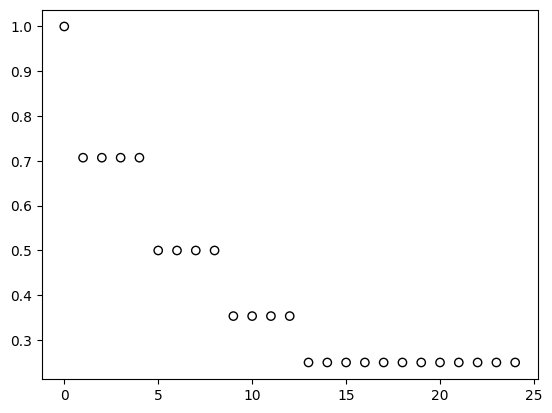

In [18]:
aug_data = tm.augment_data(tm.data)
li_lf = aug_data.scales[0:25]
sigma_i_sq = torch.exp(theta_init[6] + torch.exp(theta_init[9]) * torch.log(li_lf))
x = range(0, 25)
plt.scatter(x, sigma_i_sq.detach().numpy(), facecolors='none', edgecolors='black')

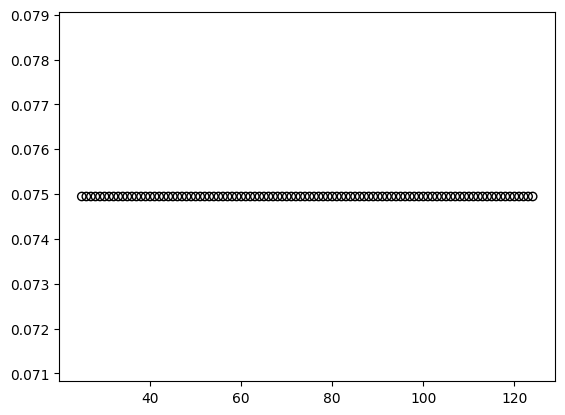

In [19]:
li_mf = aug_data.scales[25:125]
sigma_i_sq = torch.exp(theta_init[7] + torch.exp(theta_init[10]) * torch.log(li_mf))
x = range(25, 125)
plt.scatter(x, sigma_i_sq.detach().numpy(), facecolors='none', edgecolors='black')

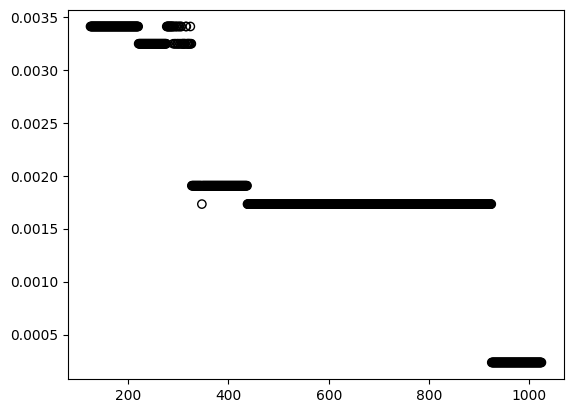

In [20]:
li_hf = aug_data.scales[125:]
sigma_i_sq = torch.exp(theta_init[8] + torch.exp(theta_init[11]) * torch.log(li_hf))
x = range(125, 1025)
plt.scatter(x, sigma_i_sq.detach().numpy(), facecolors='none', edgecolors='black')

# Nearest Neighbors

Here we observe how big are the conditioning sets for each fidelity, determined by the $\theta_q$ paramaters

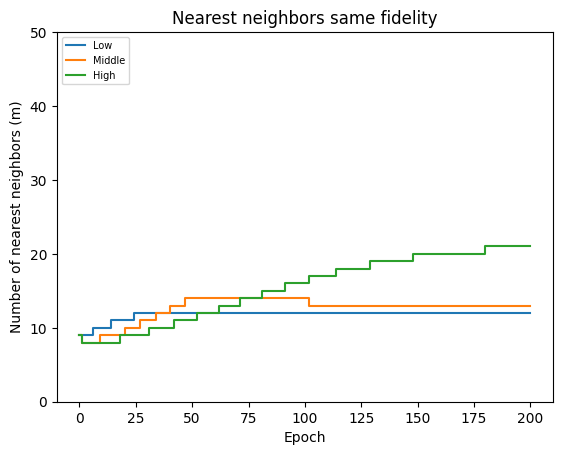

In [21]:
def det_m(max_m, theta_q_0, theta_q_1): 
    rng = torch.arange(max_m) + 1
    scales = scale(theta_q_0, theta_q_1, rng)
    mask = scales >= 0.01
    m = mask.sum()
    return m

def scale(theta_q_0, theta_q_1, k):
    theta_q_1 = torch.exp(theta_q_1)
    return torch.exp(theta_q_0 - 0.5*theta_q_1*k)

ms = []
theta_q_00 = res.param_chain["kernel.theta_q"][:nsteps+1,0] 
theta_q_10 = res.param_chain["kernel.theta_q"][:nsteps+1,3]
theta_q_01 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,1]
theta_q_11 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2,4]
theta_q_02 = res.param_chain["kernel.theta_q"][2*nsteps+2:,2]
theta_q_12 = res.param_chain["kernel.theta_q"][2*nsteps+2:,5]
thetas_q_0 = [theta_q_00, theta_q_01, theta_q_02]
thetas_q_1 = [theta_q_10, theta_q_11, theta_q_12]
for i in range(R):
    m = []
    theta_q_0 = thetas_q_0[i]
    theta_q_1 = thetas_q_1[i]
    for j in range(len(theta_q_0)):
        tq0 = torch.tensor(theta_q_0[j])
        tq1 = torch.tensor(theta_q_1[j])
        m1 = det_m(50, tq0, tq1)
        m.append(m1)
    ms.append(m)

_, ax = plt.subplots(1, 1)
epochs = np.arange(len(ms[0]))
labels = ['Low', 'Middle', 'High']
for m, label in zip(ms, labels):
    ax.step(epochs, m, label=label)
ax.set_title("Nearest neighbors same fidelity")
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of nearest neighbors (m)")
ax.set_ylim(0, data.max_m)
ax.legend(loc=2, prop={'size': 7})

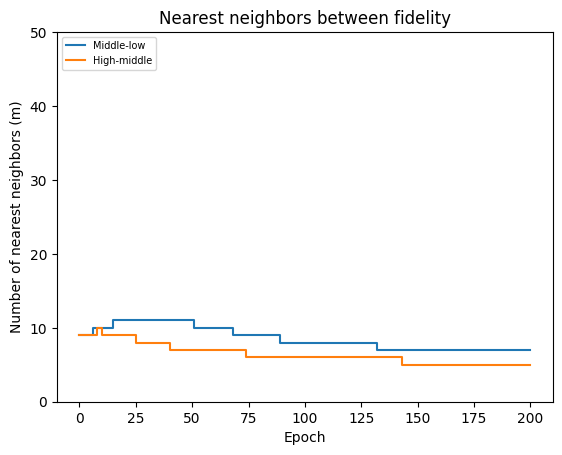

In [22]:
ms = []
theta_q_00 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 6]
theta_q_10 = res.param_chain["kernel.theta_q"][nsteps+1:2*nsteps+2, 8]
theta_q_01 = res.param_chain["kernel.theta_q"][2*nsteps+2:, 7]
theta_q_11 = res.param_chain["kernel.theta_q"][2*nsteps+2:, 9]
thetas_q_0 = [theta_q_00, theta_q_01]
thetas_q_1 = [theta_q_10, theta_q_11]
for i in range(2):
    m = []
    theta_q_0 = thetas_q_0[i]
    theta_q_1 = thetas_q_1[i]
    for j in range(len(theta_q_0)):
        tq0 = torch.tensor(theta_q_0[j])
        tq1 = torch.tensor(theta_q_1[j])
        m2 = det_m(50, tq0, tq1)
        m.append(m2)
    ms.append(m)

_, ax = plt.subplots(1, 1)
epochs = np.arange(len(ms[0]))
labels = ['Middle-low', 'High-middle']
for m, label in zip(ms, labels):
    ax.step(epochs, m, label=label)
ax.set_title("Nearest neighbors between fidelity")
ax.set_xlabel("Epoch")
ax.set_ylabel("Number of nearest neighbors (m)")
ax.set_ylim(0, data.max_m)
ax.legend(loc=2, prop={'size': 7})

In [23]:
obs = obs_test_ord[3]
obs2 = obs_test_ord[4]
sample = tm.cond_sample(obs, res, 0)
sample_uncond = sample[0]

obs_lf = sample_uncond[0:25][ord_lf.argsort()]*sd_lf + mean_lf
obs_mf = sample_uncond[25:125][ord_mf.argsort()]*sd_mf + mean_mf
obs_hf = sample_uncond[125:][ord_hf.argsort()]*sd_hf + mean_hf

# Sample from the model

Finally, Figure 4: Actually sample from the model, conditioninally or jointly, and compare against unseen (i.e. test) samples.

In [24]:
import matplotlib.pyplot as plt

# Set global font size and style
plt.rc('font', size=10)  # Default font size for text
plt.rc('axes', titlesize=12)  # Font size for axes titles
plt.rc('axes', labelsize=10)  # Font size for x and y labels
plt.rc('xtick', labelsize=8)  # Font size for x-tick labels
plt.rc('ytick', labelsize=8)  # Font size for y-tick labels
plt.rc('legend', fontsize=9)  # Font size for legend
plt.rc('figure', titlesize=12)  # Font size for figure titles

# Optional: Set font family
plt.rc('font', family='serif')  # e.g., Times New Roman for a consistent style

In [25]:
obs = obs_test_ord[4]
true_lf_1 = obs[0:25][ord_lf.argsort()]*sd_lf + mean_lf
true_mf_1 = obs[25:125][ord_mf.argsort()]*sd_mf + mean_mf
true_hf_1 = obs[125:][ord_hf.argsort()]*sd_hf + mean_hf

obs = obs_test_ord[5]
true_lf_2 = obs[0:25][ord_lf.argsort()]*sd_lf + mean_lf
true_mf_2 = obs[25:125][ord_mf.argsort()]*sd_mf + mean_mf
true_hf_2 = obs[125:][ord_hf.argsort()]*sd_hf + mean_hf

In [26]:
# Observations
obs1 = obs_test_ord[4]
obs2 = obs_test_ord[5]

true_lf_1 = obs1[0:25][ord_lf.argsort()]*sd_lf + mean_lf
true_mf_1 = obs1[25:125][ord_mf.argsort()]*sd_mf + mean_mf  
true_hf_1 = obs1[125:][ord_hf.argsort()]*sd_hf + mean_hf

true_lf_2 = obs2[0:25][ord_lf.argsort()]*sd_lf + mean_lf
true_mf_2 = obs2[25:125][ord_mf.argsort()]*sd_mf + mean_mf  
true_hf_2 = obs2[125:][ord_hf.argsort()]*sd_hf + mean_hf

# Sample conditional on mf
sample = tm.cond_sample(obs2, res, 2)
sample_cond_mf = sample[0]
sample_cond_mf_hf = sample_cond_mf[125:][ord_hf.argsort()]*sd_hf + mean_hf

# Sample conditional on lf
sample = tm.cond_sample(obs2, res, 1)
sample_cond_lf = sample[0]
sample_cond_lf_mf = sample_cond_lf[25:125][ord_mf.argsort()]*sd_mf + mean_mf
sample_cond_lf_hf = sample_cond_lf[125:][ord_hf.argsort()]*sd_hf + mean_hf

# Sample unconditional
sample = tm.cond_sample(obs2, res, 0)
sample_uncond = sample[0]

sample_uncond_lf = sample_uncond[0:25][ord_lf.argsort()]*sd_lf + mean_lf
sample_uncond_mf = sample_uncond[25:125][ord_mf.argsort()]*sd_mf + mean_mf
sample_uncond_hf = sample_uncond[125:][ord_hf.argsort()]*sd_hf + mean_hf

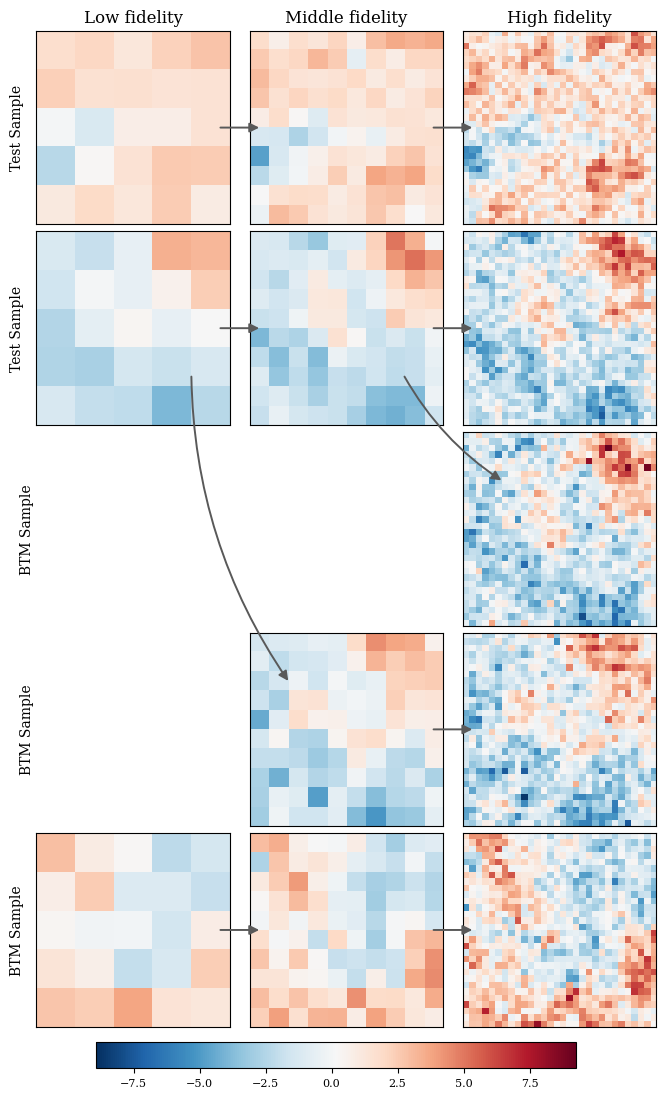

In [27]:
#gspec = {"wspace": 0.1, "hspace": 0.5}
cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under(color='lightgrey')
fig, ax = plt.subplots(5, 3, figsize=(8, 13))# gridspec_kw=gspec, squeeze=True)
plt.subplots_adjust(wspace=0.1, hspace=0.01)
#fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02)

# Observed fields
ax[0,0].imshow(true_lf_1.reshape(5, 5), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title("Low fidelity")
ax[0,0].text(-0.1, 0.5, 'Test Sample', rotation=90, va='center', ha='center', transform=ax[0,0].transAxes)

im = ax[0,1].imshow(true_mf_1.reshape(10,10), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title("Middle fidelity")

im = ax[0,2].imshow(true_hf_1.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
ax[0,2].set_title("High fidelity")

ax[1,0].imshow(true_lf_2.reshape(5, 5), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].text(-0.1, 0.5, 'Test Sample', rotation=90, va='center', ha='center', transform=ax[1,0].transAxes)

im = ax[1,1].imshow(true_mf_2.reshape(10,10), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
#ax[1,1].text(-0.1, 0.5, 'Observed', rotation=90, va='center', ha='center', transform=ax[1,1].transAxes)

im = ax[1,2].imshow(true_hf_2.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
#ax[1,2].set_title("True High fidelity")

# Samples from BTM model
ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_frame_on(False)
ax[2,0].text(-0.05, 0.5, 'BTM Sample', rotation=90, va='center', ha='center', transform=ax[2,0].transAxes)

ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].set_frame_on(False)

ax[2,2].imshow(sample_cond_mf_hf.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[2,2].set_xticks([])
ax[2,2].set_yticks([])

ax[3,0].set_xticks([])
ax[3,0].set_yticks([])
ax[3,0].set_frame_on(False)
ax[3,0].text(-0.05, 0.5, 'BTM Sample', rotation=90, va='center', ha='center', transform=ax[3,0].transAxes)

im = ax[3,1].imshow(sample_cond_lf_mf.reshape(10, 10), vmin=vmin, vmax=vmax, cmap=cmap)
ax[3,1].set_xticks([])
ax[3,1].set_yticks([])

im = ax[3,2].imshow(sample_cond_lf_hf.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[3,2].set_xticks([])
ax[3,2].set_yticks([])

im = ax[4,0].imshow(sample_uncond_lf.reshape(5, 5), vmin=vmin, vmax=vmax, cmap=cmap)
ax[4,0].set_xticks([])
ax[4,0].set_yticks([]) 
ax[4,0].text(-0.1, 0.5, 'BTM Sample', rotation=90, va='center', ha='center', transform=ax[4,0].transAxes)

ax[4,1].imshow(sample_uncond_mf.reshape(10, 10), vmin=vmin, vmax=vmax, cmap=cmap)
ax[4,1].set_xticks([])
ax[4,1].set_yticks([])

im = ax[4,2].imshow(sample_uncond_hf.reshape(30, 30), vmin=vmin, vmax=vmax, cmap=cmap)
ax[4,2].set_xticks([])
ax[4,2].set_yticks([])

from matplotlib.patches import ConnectionPatch

def connect(ax_from, ax_to, start=(0.95, 0.5), end=(0.05, 0.5),
            rad=0.0, color="k", lw=1.4, ms=14):
    """
    Draw an arrow from ax_from to ax_to using axes-fraction coords.
    start/end are (x,y) in the source/target axes (0..1).
    rad controls a slight curve; use 0 for straight.
    """
    con = ConnectionPatch(
        start, end,
        coordsA=ax_from.transAxes, coordsB=ax_to.transAxes,
        arrowstyle="-|>", mutation_scale=ms,
        lw=lw, color=color,
        connectionstyle=f"arc3,rad={rad}",
        shrinkA=0, shrinkB=0, clip_on=False
    )
    con.set_zorder(10)   # keep arrows above images
    fig.add_artist(con)

a_21 = ax[1, 0]  # (2,1)
a_42 = ax[3, 1]  # (4,2)
a_22 = ax[1, 1]  # (2,2)
a_33 = ax[2, 2]  # (3,3)
a_43 = ax[3, 2]  # (4,3)
a_51 = ax[4, 0]  # (5,1)
a_52 = ax[4, 1]  # (5,2)
a_53 = ax[4, 2]  # (5,3)

connect(a_21, a_42, start=(0.80, 0.25), end=(0.20, 0.75), rad=0.15, color='0.35')

# (2,2) -> (3,3): diagonal down-right
connect(a_22, a_33, start=(0.80, 0.25), end=(0.20, 0.75), rad=0.12, color='0.35')

# (4,2) -> (4,3): same row, straight right
connect(a_42, a_43, start=(0.95, 0.50), end=(0.05, 0.50), rad=0.0, color='0.35')

# (5,1) -> (5,2) -> (5,3): chain along bottom row
connect(a_51, a_52, start=(0.95, 0.50), end=(0.05, 0.50), rad=0.0, color='0.35')
connect(a_52, a_53, start=(0.95, 0.50), end=(0.05, 0.50), rad=0.0, color='0.35')

# Top row: (0,0) -> (0,1) -> (0,2)
connect(ax[0,0], ax[0,1], start=(0.95, 0.50), end=(0.05, 0.50), rad=0.0, color='0.35')
connect(ax[0,1], ax[0,2], start=(0.95, 0.50), end=(0.05, 0.50), rad=0.0, color='0.35')

# Second row: (1,0) -> (1,1) -> (1,2)
connect(ax[1,0], ax[1,1], start=(0.95, 0.50), end=(0.05, 0.50), rad=0.0, color='0.35')
connect(ax[1,1], ax[1,2], start=(0.95, 0.50), end=(0.05, 0.50), rad=0.0, color='0.35')

cbar = fig.add_axes([0.2, 0.08, 0.6, 0.02]) 
fig.colorbar(im, cax=cbar, orientation="horizontal")
OUTPUT_FILE = "samples_all.pdf"
DPI = 500  # Specify the DPI
# Uncomment to save on file
#fig.savefig(OUTPUT_FILE, format='pdf', dpi=DPI, bbox_inches='tight')

# Scores

To test the score fuctionality, use the function `score`, which outputs a vector that contains each locations log-likelihoods contribution (in the maximin order). You can start scoring at certain fidelities using the second parameter. 

In [29]:
sc = tm.score(obs_test_ord[19], 0)
-sc.sum()

tensor(776.8671)